# Netflix Analysis & Recommendation System


Based on the movie-watching data from Netflix, I focused on building a movie recommendation system for users, aiming to enhance their viewing experience by providing personalized movie suggestions. Let's get startred!

We firstly imported the packaged we needed. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
import math
from surprise.accuracy import rmse
from math import sqrt


### 1. Data Cleaning & Preprocessing

The datasets used in this analysis are obtained from Kaggle. There are two kinds of datasets in total. The first one contains customers' ratings of each movie on different dates. The second one includes each movie’s ID and the corresponding titles and release years.

#### combined_data_1.txt:

- **MovieID**: unique ID for movies
- **CustomerID**: unique ID for Netflix users
- **Rating**: the rating users gave to movies, on a scale from 1 to 5
- **Date**: the date users watched the movies

#### movie_titles.csv:

- **MovieID**: unique ID for movies
- **Year**: the year the movie was first released
- **Title**: name of the movies/TV shows



In [2]:
# read the movie_titles.csv file and convert it into dataframe named movie_titles

with open('movie_titles.csv', 'r', encoding='utf-8', errors='replace') as f:
    movie_title = f.readlines()

data = []

for line in movie_title:
    # Split the line by commas
    parts = line.strip().split(',')
    # Check if the line has the correct number of components
    if len(parts) >= 3:
        # Extract the ID, Year, and Title from the line
        ID = parts[0]
        Year = parts[1]
        Title = ','.join(parts[2:])
        # Append the extracted data to the list
        data.append([ID, Year, Title])


movie_titles = pd.DataFrame(data, columns=['ID', 'Year', 'Title'])

movie_titles

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [4]:
# read the combined_data_1.txt and convert it into dataframe named df

df = pd.DataFrame(columns=["movie_id", "user_id", "user_rating", "user_date"])

file_path = 'combined_data_1.txt'
movie_id = None

data = []

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        # Check if the line contains a movie_id
        if ':' in line:
            movie_id = line.replace(':', '').strip()
        else:
            user_id, user_rating, user_date = line.split(',')
            data.append({
                "movie_id": movie_id,
                "user_id": user_id.strip(),
                "user_rating": user_rating.strip(),
                "user_date": user_date.strip()
            })

data_1 = pd.DataFrame(data)

data_1

,movie_id,user_id,user_rating,user_date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
24053759,4499,2591364,2,2005-02-16
24053760,4499,1791000,2,2005-02-10
24053761,4499,512536,5,2005-07-27
24053762,4499,988963,3,2005-12-20


Due to the limitations of our computer's CPU capacity, we decided to reduce the dataset size. To do so, we removed rows at even positions.

In [5]:
# removed rows at even positions
data = data_1[data_1.index % 2 == 0].reset_index(drop="True")
data

,movie_id,user_id,user_rating,user_date
0,1,1488844,3,2005-09-06
1,1,885013,4,2005-10-19
2,1,823519,3,2004-05-03
3,1,124105,4,2004-08-05
4,1,1842128,4,2004-05-09
...,...,...,...,...
12026877,4499,272857,4,2005-06-22
12026878,4499,2219917,3,2004-05-03
12026879,4499,2562830,4,2004-06-19
12026880,4499,1791000,2,2005-02-10


Then we combined these 2 dataframe.

In [6]:
movie_data = pd.merge(data, movie_titles, left_on="movie_id", right_on="ID")
movie_data.drop(columns=['ID'], inplace=True)

In [7]:
movie_data

,movie_id,user_id,user_rating,user_date,Year,Title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,885013,4,2005-10-19,2003,Dinosaur Planet
2,1,823519,3,2004-05-03,2003,Dinosaur Planet
3,1,124105,4,2004-08-05,2003,Dinosaur Planet
4,1,1842128,4,2004-05-09,2003,Dinosaur Planet
...,...,...,...,...,...,...
12026877,4499,272857,4,2005-06-22,2002,In My Skin
12026878,4499,2219917,3,2004-05-03,2002,In My Skin
12026879,4499,2562830,4,2004-06-19,2002,In My Skin
12026880,4499,1791000,2,2005-02-10,2002,In My Skin


In [8]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12026882 entries, 0 to 12026881
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   movie_id     object
 1   user_id      object
 2   user_rating  object
 3   user_date    object
 4   Year         object
 5   Title        object
dtypes: object(6)
memory usage: 550.5+ MB


### Basic Data Cleaning

Now, it's time for us to clean the data after obtaining the DataFrame. We will first check for missing values, then fill the null values by web scraping, and finally change the data types.

In [9]:
# check missing value
movie_data.isin(['NULL']).sum()

movie_id        0
user_id         0
user_rating     0
user_date       0
Year           95
Title           0
dtype: int64

In [10]:
# extract the null value dataframe
null_year_df = movie_data[movie_data['Year'] == 'NULL']

In [11]:
# use web scraping to fill missing value
def fetch_release_date(name):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.5'
    }

    url = f"https://www.amazon.com/s?k={name.replace(' ', '+')}"

    response = requests.get(url, headers=headers).content
    soup = BeautifulSoup(response, 'html.parser')

    try:
        result = soup.find('a', {'class': 'a-link-normal s-no-outline'}).get('href')
        product_url = f"https://www.amazon.com{result}"

        product_response = requests.get(product_url, headers=headers).content
        product_soup = BeautifulSoup(product_response, 'html.parser')

        # Find the text "Release date"
        release_date_span = product_soup.find('span', string=lambda text: text and 'Release date' in text)
        if release_date_span:
            # Extract the text of the next sibling span
            date = release_date_span.find_next_sibling('span').text.strip()
            mon, year = date.split(', ')
            return year
        else:
            return "NULL"
    except:
        return "NULL"

In [12]:
# Dictionary to store fetched release years for each movie title
fetched_release_years = {}

for index, row in null_year_df.iterrows():
    movie_title = row['Title']

    # Check if the release year for this title has been fetched before
    if movie_title in fetched_release_years:
        null_year_df.at[index, 'Year'] = fetched_release_years[movie_title]
    else:
        # Fetch the release year and store it
        release_year = fetch_release_date(movie_title)
        null_year_df.at[index, 'Year'] = release_year
        fetched_release_years[movie_title] = release_year

In [13]:
# Update the original data
movie_data.update(null_year_df)

In [19]:
# check in there's missing value again
movie_data.isin(['NULL']).sum()

movie_id       0
user_id        0
user_rating    0
user_date      0
Year           0
Title          0
dtype: int64

In [20]:
# change data type
movie_data['movie_id'] = movie_data['movie_id'].astype(int)
movie_data['user_id'] = movie_data['user_id'].astype(int)
movie_data['user_rating'] = movie_data['user_rating'].astype(int)
movie_data['Year'] = movie_data['Year'].astype(int)
movie_data['user_date'] = pd.to_datetime(movie_data['user_date'])

In [21]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12026882 entries, 0 to 12026881
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movie_id     int64         
 1   user_id      int64         
 2   user_rating  int64         
 3   user_date    datetime64[ns]
 4   Year         int64         
 5   Title        object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 550.5+ MB


In [22]:
movie_data

,movie_id,user_id,user_rating,user_date,Year,Title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,885013,4,2005-10-19,2003,Dinosaur Planet
2,1,823519,3,2004-05-03,2003,Dinosaur Planet
3,1,124105,4,2004-08-05,2003,Dinosaur Planet
4,1,1842128,4,2004-05-09,2003,Dinosaur Planet
...,...,...,...,...,...,...
12026877,4499,272857,4,2005-06-22,2002,In My Skin
12026878,4499,2219917,3,2004-05-03,2002,In My Skin
12026879,4499,2562830,4,2004-06-19,2002,In My Skin
12026880,4499,1791000,2,2005-02-10,2002,In My Skin


## Exploratory Data Analysis (EDA)

In this section, we will perform exploratory data analysis to understand the structure and characteristics of our dataset. 

### User Rating Distribution

We were curious about the overall rating distribution. From the histogram below, we can see that most ratings are concentrated around 4.

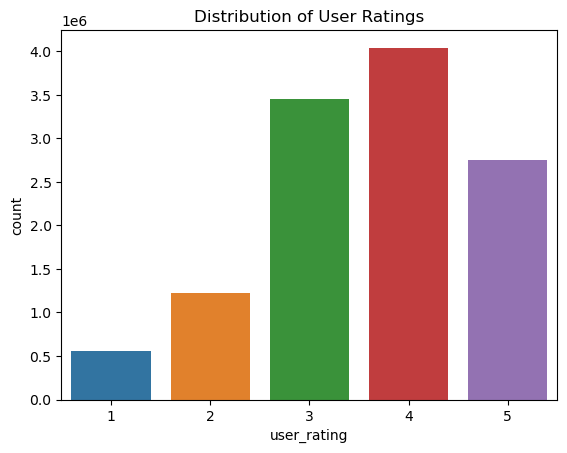

In [23]:
sns.countplot(x='user_rating', data=movie_data)
plt.title('Distribution of User Ratings')
plt.show()

### Every Year Movie Title Trend that Users watched from 1999 to 2005

We were curious about the types of movie titles users watched from 1999 to 2005, so we plotted a word cloud to investigate. From this plot, we observed that users tended to watch love and letter-related movies in 1999. Subsequently, their preferences shifted towards vampire-themed and life/living-related movies between 2000 and 2002. Finally, they preferred season series types from 2003 to 2005.

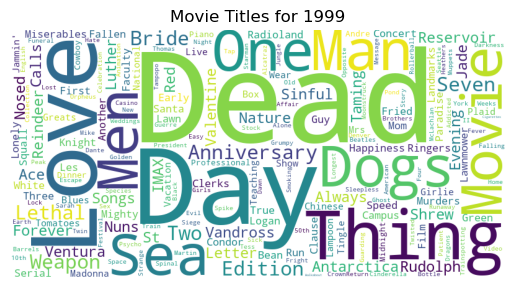

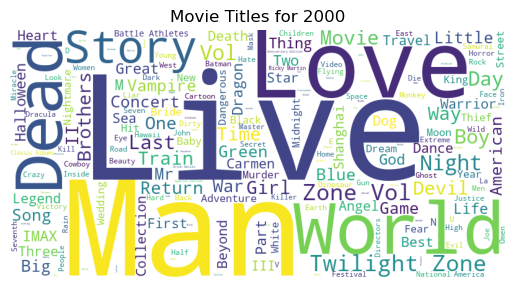

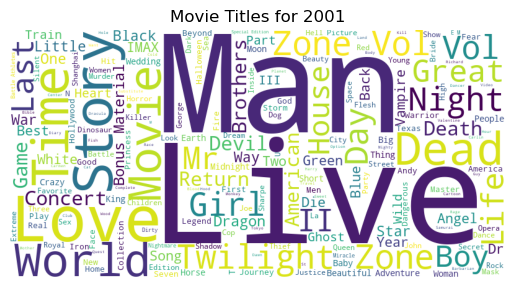

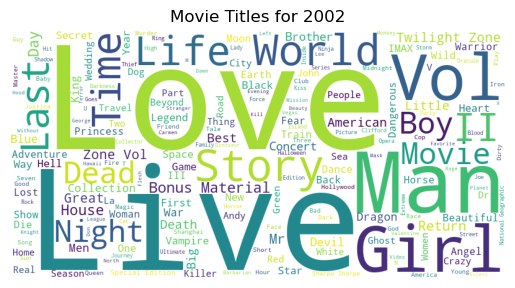

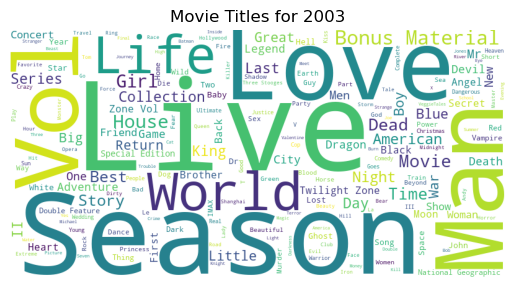

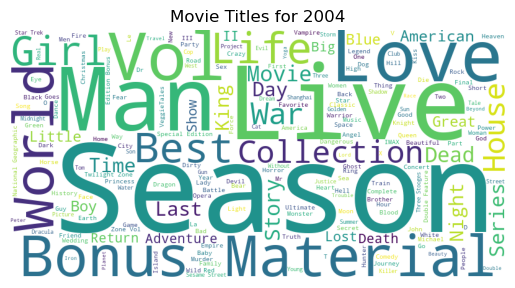

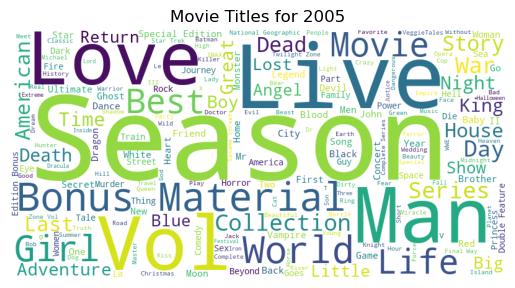

In [24]:
movie_data['User_Year'] = movie_data['user_date'].dt.year
grouped_by_year = movie_data.groupby('User_Year')

for year, group_data in grouped_by_year:
    movie_titles = group_data['Title'].unique()

    movie_titles_string = ' '.join(movie_titles)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(movie_titles_string)

    plt.imshow(wordcloud)
    plt.title(f'Movie Titles for {year}')
    plt.axis('off')
    plt.show()

### Every year Top 10 reviewed movie

Our goal was to showcase the top 10 films reviewed each year, providing users with annual rankings so that they can discover the most popular ones each year. The bar charts illustrate these lists, offering insights into both yearly favorites and overall top picks. Interestingly, the data suggests a notable rise in Netflix usage over the period, reflected in the increasing number of movie reviews year by year.

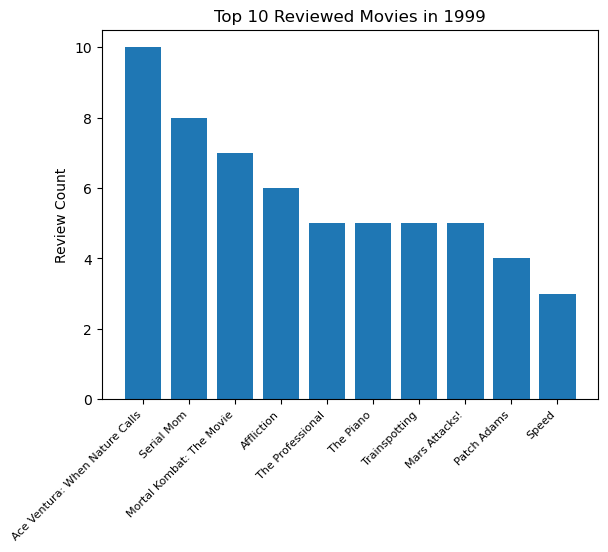

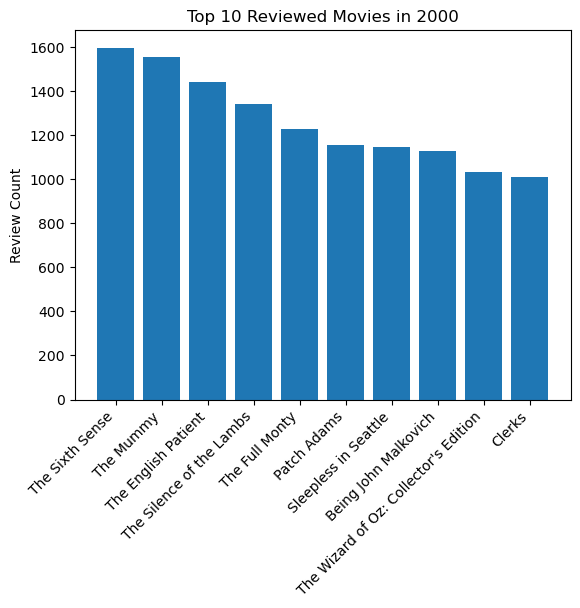

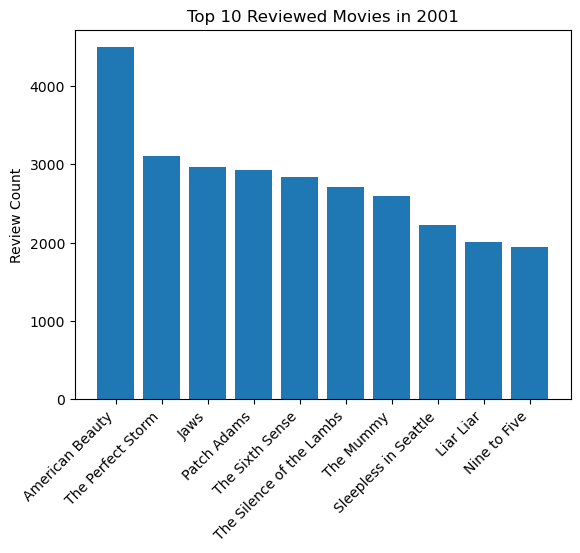

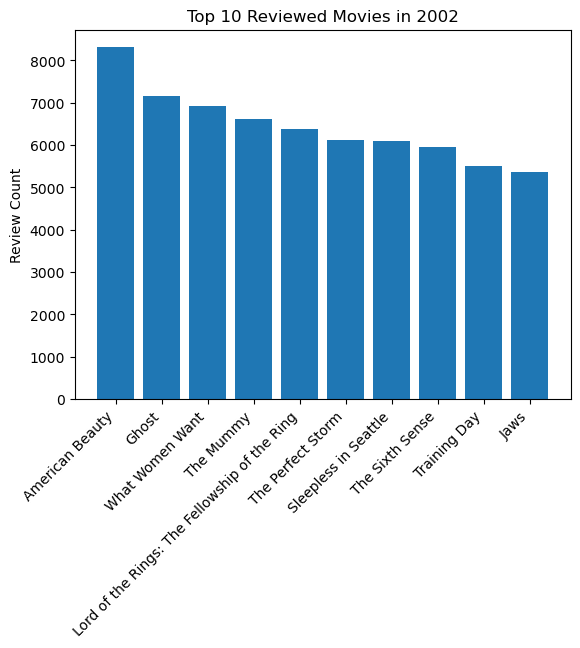

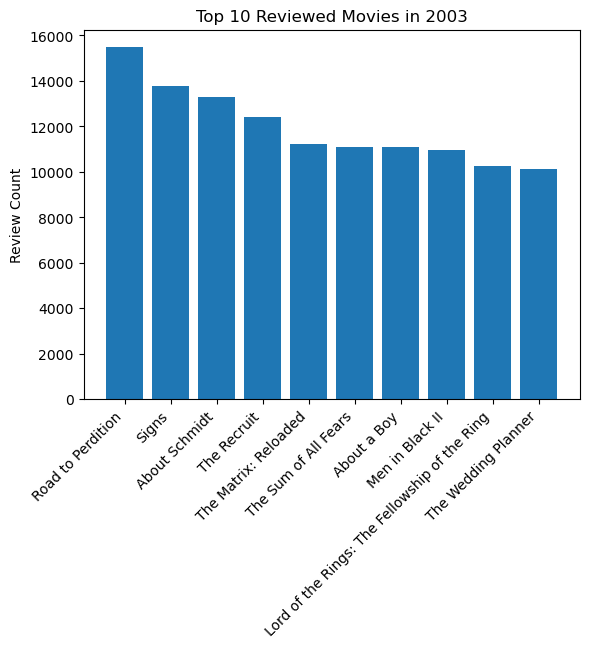

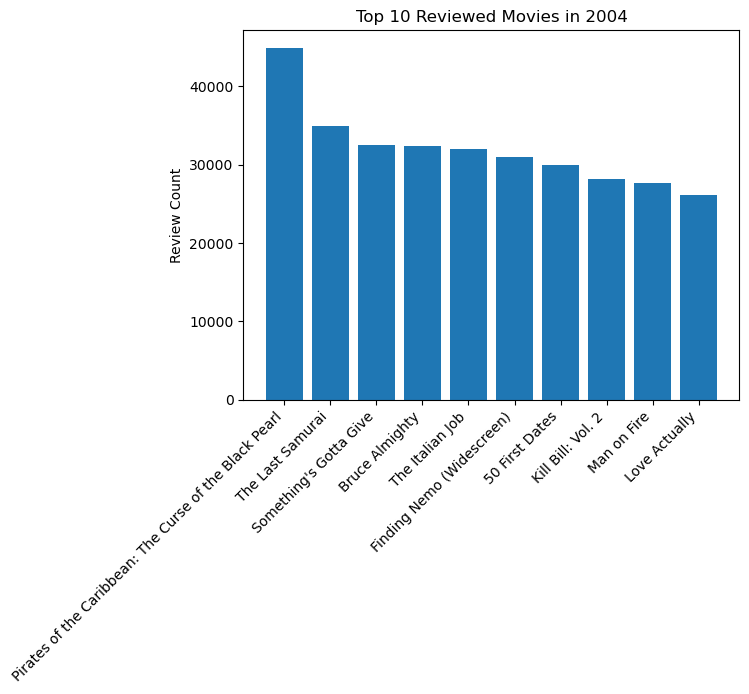

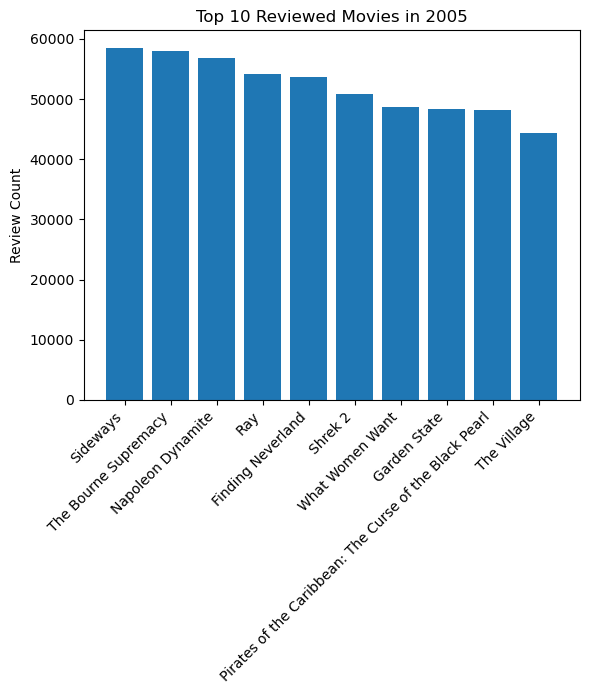

In [25]:
plt.xticks(rotation=45, ha='right', fontsize=8)
grouped_by_year = movie_data.groupby('User_Year')

for year, group_data in grouped_by_year:

    movie_review_counts = group_data['Title'].value_counts()
    top_10_movies_year = movie_review_counts.nlargest(10)

    plt.bar(top_10_movies_year.index, top_10_movies_year.values)

    plt.title(f'Top 10 Reviewed Movies in {year}')
    plt.ylabel('Review Count')
    plt.xticks(rotation=45, ha='right')

    plt.show()

### Total Top 10 reviewed movie throughout the entire period (1999-2005)

In this part, we aimed to summarize the overall top 10 reviewed movies throughout the entire period (1999-2005), highlighting the films that received the most attention and highest ratings during these years.

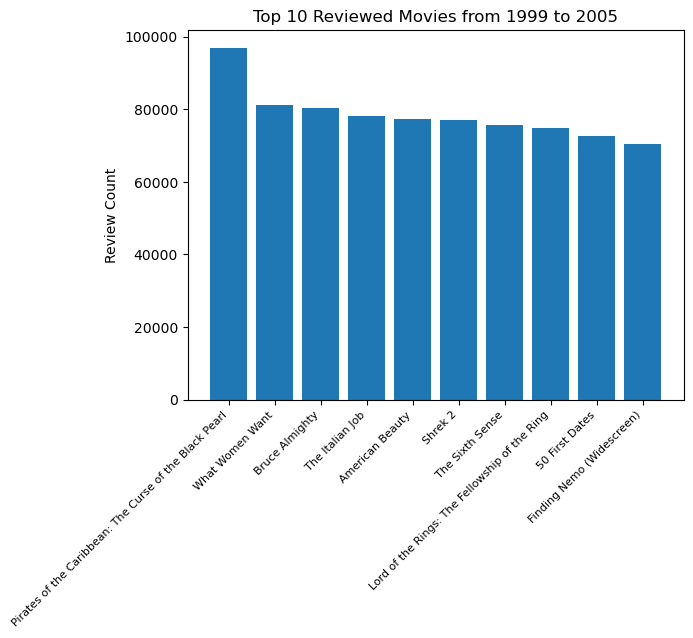

In [26]:
movie_review_counts = movie_data['Title'].value_counts()

top_10_review_movies = movie_review_counts.nlargest(10)

plt.bar(top_10_review_movies.index, top_10_review_movies.values)

plt.title('Top 10 Reviewed Movies from 1999 to 2005')
plt.ylabel('Review Count')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.show()


### Every year Top 10 rating movie

In this section, we aimed to present the top 10 movies with the highest average ratings for each year, allowing users to discover which movies were most highly rated by other users. To achieve this, we generated a series of bar charts depicting the top 10 highest-rated movies for each year, as well as a compilation of the overall top 10 highest-rated movies to date. Interestingly, upon comparing these charts with the previously analyzed top 10 reviewed movies, we observed that movies with the highest number of reviews did not necessarily have the highest ratings. In other words, high ratings did not guarantee a large review.

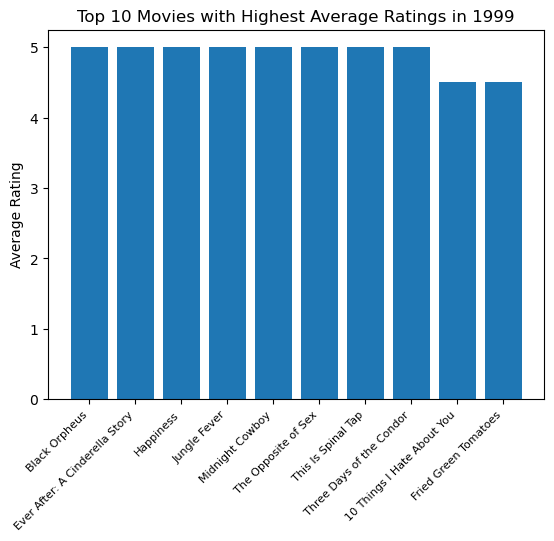

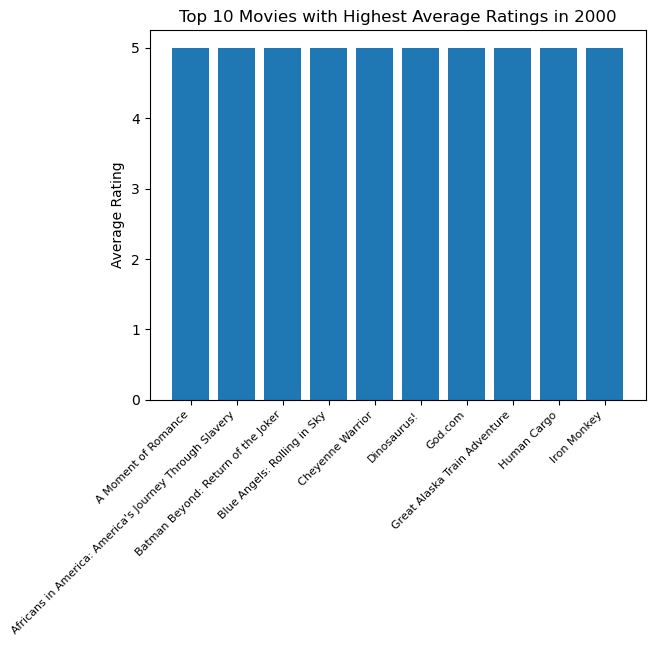

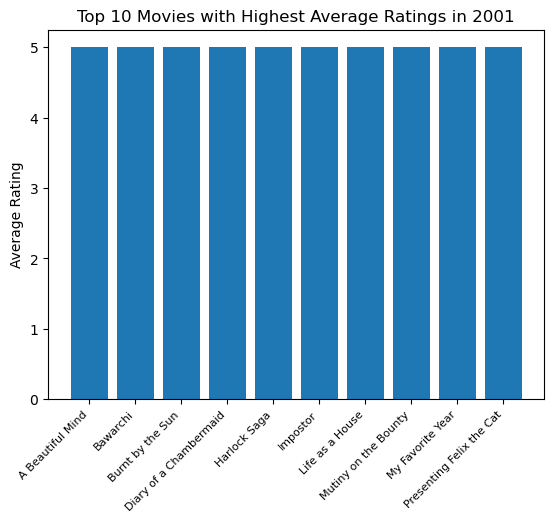

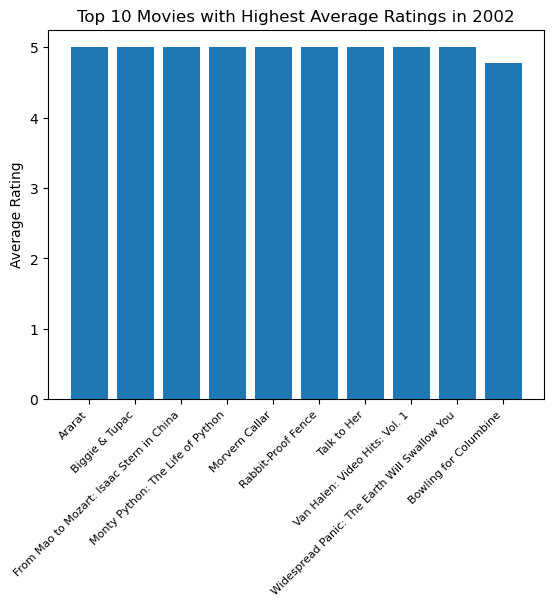

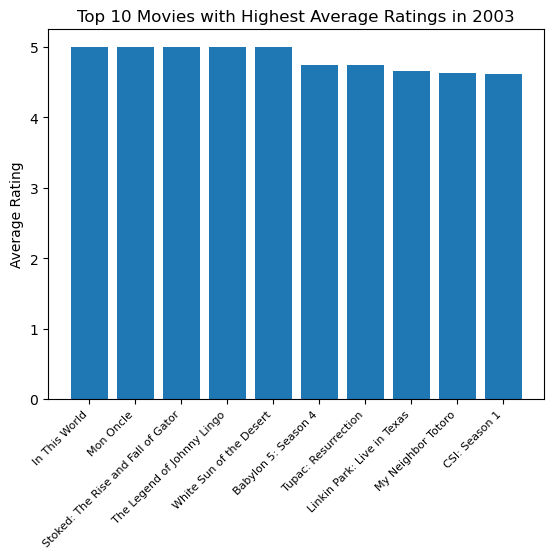

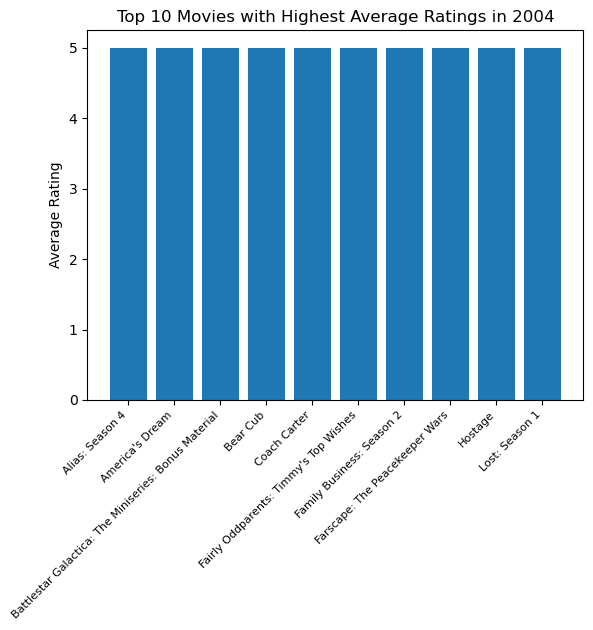

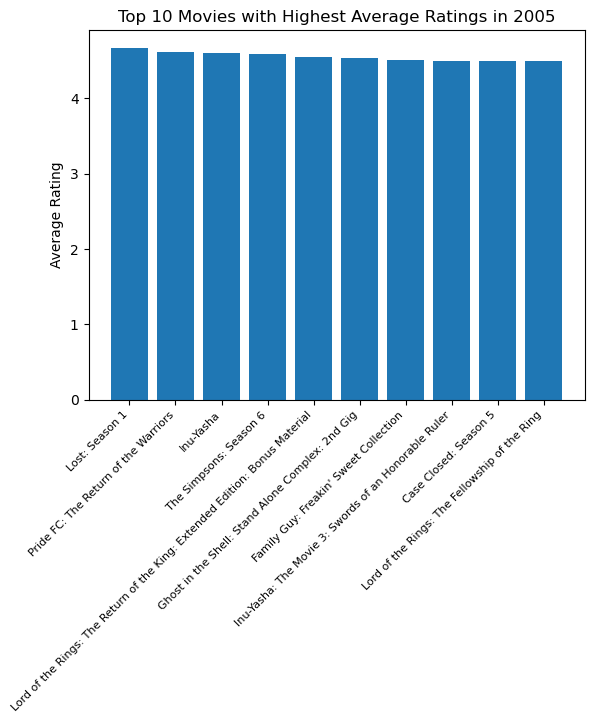

In [27]:
for year, group_data in grouped_by_year:
    avg_rating_by_movie = group_data.groupby('Title')['user_rating'].mean()
    top_10_avg_rating_movies = avg_rating_by_movie.nlargest(10)

    movie_titles = top_10_avg_rating_movies.index
    avg_ratings = top_10_avg_rating_movies.values

    plt.bar(movie_titles, avg_ratings)

    plt.title(f'Top 10 Movies with Highest Average Ratings in {year}')
    plt.ylabel('Average Rating')

    plt.xticks(rotation=45, ha='right', fontsize=8)

    plt.show()

### Total Top 10 rating movie from 1999 to 2005

In this section, we aimed to summarize the top 10 highest-rated movies from 1999 to 2005. Our goal was to identify the films that received the most favorable reviews during this period, which we can feature on the landing page for users to see what had the highest rating.

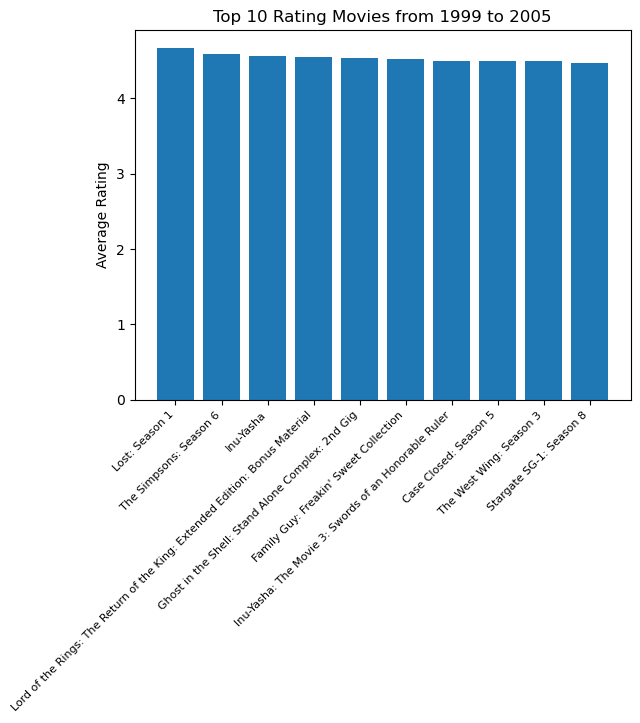

In [28]:
avg_rating_by_movie = movie_data.groupby('Title')['user_rating'].mean()

top_10_avg_rating_movies = avg_rating_by_movie.nlargest(10)

movie_titles = top_10_avg_rating_movies.index
avg_ratings = top_10_avg_rating_movies.values

plt.bar(top_10_avg_rating_movies.index, top_10_avg_rating_movies.values)
plt.title('Top 10 Rating Movies from 1999 to 2005')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.show()

### Data Split for Training, Validation, and Testing

we divided our dataset into three distinct subsets: the training set, the validation set, and the testing set. Considering the time-series aspect of our data collection, we chose a chronological split instead of a random one. Initially, we sorted the data by the user-watching date to maintain temporal coherence. Subsequently, we assigned the first 80% of the sorted data to the training set, followed by 10% for the validation set, and the remaining 10% for the testing set. This method not only ensured that our model training and evaluations reflect the real-world scenarios, but it also prevented the issue of data leakage.


In [38]:
# due to time series data, we first sorted our date by date
sorted_data = movie_data.sort_values(by='user_date')

train_valid_cutoff = sorted_data['user_date'].quantile(0.8)
valid_test_cutoff = sorted_data['user_date'].quantile(0.9)

train = sorted_data[sorted_data['user_date'] <= train_valid_cutoff]
valid = sorted_data[(sorted_data['user_date'] > train_valid_cutoff) & (sorted_data['user_date'] < valid_test_cutoff)]
test = sorted_data[sorted_data['user_date'] > valid_test_cutoff]


In [39]:
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Data Modeling

In this model, we combined two algorithms to enhance the accuracy of our recommendation system. 

In [40]:
# Load the data into Surprise Dataset
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train[['user_id', 'movie_id', 'user_rating']], reader)
valid_data = Dataset.load_from_df(valid[['user_id', 'movie_id', 'user_rating']], reader)
test_data = Dataset.load_from_df(test[['user_id', 'movie_id', 'user_rating']], reader)

In [41]:
# Convert data to Surprise Model
trainset = train_data.build_full_trainset()
validset = valid_data.build_full_trainset().build_testset()
testset = test_data.build_full_trainset().build_testset()

Firstly, we used Singular Value Decomposition (SVD), a matrix factorization technique, utilizing movie IDs, user IDs, and ratings to predict individual movie ratings for users. This approach resulted in a Root Mean Square Error (RMSE) of 1.0042. 

In [42]:
# Train SVD model
model_svd = SVD()
model_svd.fit(trainset)

predictions_svd = model_svd.test(validset)
print("RMSE:", accuracy.rmse(predictions_svd))

RMSE: 1.0047
RMSE: 1.0046841544488805


Secondly, we used the K-Nearest Neighbors (KNN) algorithm, with a default setting of k=40 neighbors, using cosine similarity and an item-based approach for rating prediction. This method yielded an RMSE of 1.0934.


In [43]:
# use item-based cosine similarity

# Train KNN model
model_knn = KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False})
model_knn.fit(trainset)

predictions_knn = model_knn.test(validset)
print("RMSE:", accuracy.rmse(predictions_knn))


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0934
RMSE: 1.0934431277488075


To refine our recommendation system, we adopted a hybrid approach, which involved weighting the predictions from both SVD and KNN models. We determined the optimal weights by evaluating various combinations on a validation set. The best performance was achieved with a weight of 0.89 for the SVD model and 0.11 for the KNN model.


In [44]:
weights_svd = np.linspace(0, 1, 10)
weights_knn = 1 - weights_svd

best_rmse = float('inf')
best_weights = None

# Iterate over each weight combination
for weight_svd, weight_knn in zip(weights_svd, weights_knn):
    combined_rmse = 0.0

    for uid, iid, true_r in validset:
        est_svd = model_svd.predict(uid, iid).est
        est_knn = model_knn.predict(uid, iid).est

        # Combine predictions using the current weights
        est_combined = (weight_svd * est_svd) + (weight_knn * est_knn)

        # Calculate error and RMSE
        error = true_r - est_combined
        combined_rmse += error ** 2

    combined_rmse = math.sqrt(combined_rmse / len(validset))

    # Update the best RMSE and weights if this combination performs better
    if combined_rmse < best_rmse:
        best_rmse = combined_rmse
        best_weights = (weight_svd, weight_knn)

print("Best Combined Model RMSE:", best_rmse)
print("Best Weights (SVD, KNN):", best_weights)

Best Combined Model RMSE: 1.0034834221178974
Best Weights (SVD, KNN): (0.8888888888888888, 0.11111111111111116)


After establishing the optimal weights, we retrained both models using a combined dataset of training and validation sets to prepare them for final testing. 

In [45]:
new_cutoff = sorted_data['user_date'].quantile(0.90)
train = sorted_data[sorted_data['user_date'] <= new_cutoff]
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train[['user_id', 'movie_id', 'user_rating']], reader)
trainset = train_data.build_full_trainset()

In [46]:
model_svd = SVD()
model_svd.fit(trainset)

In [48]:
model_knn = KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False})
model_knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Upon evaluating the hybrid model on the test set, we observed a reduced RMSE of 0.9876. This improvement confirms that our hybrid recommendation system, leveraging both SVD and KNN algorithms, significantly enhances prediction accuracy.

In [49]:
predictions_svd = model_svd.test(testset)
predictions_knn = model_knn.test(testset)

In [50]:
weight_svd = 0.89
weight_knn = 0.11

combined_rmse = 0.0
num_predictions = 0

for uid, iid, true_r in testset:
    est_svd = model_svd.predict(uid, iid).est
    est_knn = model_knn.predict(uid, iid).est

    # Combine predictions using the predefined weights
    est_combined = (weight_svd * est_svd) + (weight_knn * est_knn)

    # Calculate error and RMSE
    error = true_r - est_combined
    combined_rmse += error ** 2
    num_predictions += 1

combined_rmse = math.sqrt(combined_rmse / num_predictions)

print("Combined Model RMSE:", combined_rmse)

Combined Model RMSE: 0.9876552083119612
